### Importing necessary packages and modules

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Pre-processing the dataset : 
##### Images are of various sizes, need to get all the images to the same size

In [2]:
#Defining the variables for the size of an image
rows = 64 #height of the image
cols = 64 #width of the image
channels = 3 #RGB-Red, Blue, Green
#Assigning the dataset folder location to the variables 
train_dir = './train/'
test_dir = './test1/'

In [3]:
#Storing all the images as a list in following variables
train_images = [train_dir+i for i in os.listdir(train_dir)]
test_images = [test_dir+i for i in os.listdir(test_dir)]

In [4]:
#Creating a function to resize every image it gets
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (rows,cols), interpolation=cv2.INTER_CUBIC)

In [5]:
#Creating a function which assigns 1 to a dog image and 0 to a cat image
def prepare_data(images):
    m = len(images)
    x = np.zeros((m, rows, cols, channels), dtype=np.uint8) #image
    y = np.zeros((1,m)) #output
    for i, image_file in enumerate(images):
        x[i,:] = read_image(image_file)
        if 'dog' in image_file.lower(): #all the images in the folder are named as cats and dogs
            y[0,i] = 1
        elif 'cat' in image_file.lower():
            y[0,i] = 0
        if i%5000 == 0 :
            print("Proceed {} of {}".format(i, m))
    return x, y    

In [6]:
#Reading all train and test images into respective numpy arrays
train_set_x, train_set_y = prepare_data(train_images)
test_set_x, test_set_y = prepare_data(test_images)

Proceed 0 of 25000
Proceed 5000 of 25000
Proceed 10000 of 25000
Proceed 15000 of 25000
Proceed 20000 of 25000
Proceed 0 of 12500
Proceed 5000 of 12500
Proceed 10000 of 12500


In [7]:
#Re-shaping images of shape (rows, cols, channels) into single vectors of shape (rows*cols*channels,1)
#Each column represents a flattened image.
train_set_x_flatten = train_set_x.reshape(train_set_x.shape[0], rows*cols*channels).T
test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0], -1).T

In [8]:
#Printing all the shapes
print("train_set_x shape: "+str(train_set_x.shape))
print("train_set_x_flatten shape: "+str(train_set_x_flatten.shape))
print("train_set_y shape: "+str(train_set_y.shape))
print("test_set_x shape: "+str(test_set_x.shape))
print("test_set_x_flatten shape: "+str(test_set_x_flatten.shape))
print("test_set_y shape: "+str(test_set_y.shape))

train_set_x shape: (25000, 64, 64, 3)
train_set_x_flatten shape: (12288, 25000)
train_set_y shape: (1, 25000)
test_set_x shape: (12500, 64, 64, 3)
test_set_x_flatten shape: (12288, 12500)
test_set_y shape: (1, 12500)


In [9]:
#Standardizing dataset, by dividing every row by 255(max value of a pixel)
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

### Algorithm

In [10]:
#Sigmoid function 
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [11]:
#Initialize a vector of zeros of shape (dim,1) for w and b to 0
#dim = number of parameters
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    return w,b

In [12]:
#Forward and Backward propagation, w=weights(numpy array), b=bias, X=data of size(rows*cols*channels,number of training examples), y=label of shape(1,number of training examples)
def propagate(w,b,x,y):
    m = x.shape[1] #number of training examples
    #Forward propagation
    z = np.dot(w.T, x)+b
    A = sigmoid(z)
    cost = (-np.sum(y*np.log(A)+(1-y)*np.log(1-A)))/m
    #Backward propagation
    dw = (np.dot(x,(A-y).T))/m
    db = (np.sum(A-y))/m
    cost = np.squeeze(cost)
    grads = {"dw": dw,
             "db": db}
    return grads, cost

In [59]:
#Optimization
def optimize(w,b,x,y,num_iterations,learning_rate,print_cost=False):
    costs = []
    for i in range(num_iterations):
        
        #cost and gradient
        grads, cost = propagate(w,b,x,y)
        
        #retrieve derivates
        dw = grads["dw"]
        db = grads["db"]
        
        #update
        w = w-(learning_rate*dw)
        b = b-(learning_rate*db)
        
        #Recording costs
        if i%100 == 0:
            costs.append(cost)
            
        #Print the cost every 100 training iterations
        if print_cost and i%200 == 0:
            print("Cost after iteration %i: %f" %(i,cost))
    #Update w and b to dictionary
    params = {"w": w,
             "b": b}
    #Update derivates to dictionary
    grads = {"dw": dw,
            "db": db}
    return params, grads, costs

In [14]:
#Prediction
def predict(w,b,x):
    m = x.shape[1]
    y_prediction = np.zeros((1,m))
    w = w.reshape(x.shape[0],1)
    #
    A = sigmoid(np.dot(w.T,x)+b)
    
    for i in range(A.shape[1]):
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0,i] > 0.5:
            y_prediction[[0],[i]] = 1
        else: 
            y_prediction[[0],[i]] = 0
    
    return y_prediction

In [60]:
#model
def model(x_train, y_train, x_test, y_test, num_iterations, learning_rate, print_cost=False):
    w, b = initialize_with_zeros(x_train.shape[0])
    
    parameters, grads, costs = optimize(w,b,x_train,y_train,num_iterations,learning_rate,print_cost=True)
    
    w=parameters["w"]
    b=parameters["b"]
    
    y_prediction_test = predict(w,b,x_test)
    y_prediction_train = predict(w,b,x_train)
    
    print("train accuracy: {}%".format(100-np.mean(np.abs(y_prediction_train - y_train))*100))
    print("test accuracy: {}%".format(100-np.mean(np.abs(y_prediction_test - y_test))*100))
    
    dict = {"costs": costs,
            "y_prediction_test": y_prediction_test,
            "y_prediction_train": y_prediction_train,
            "w": w,
            "b": b,
            "learning_rate": learning_rate,
            "num_iterations": num_iterations
    }
    return dict

In [50]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 3000, learning_rate = 0.003, print_cost = False)

Cost after iteration 0: 0.693147
Cost after iteration 100: 1.351262
Cost after iteration 200: 1.307533
Cost after iteration 300: 1.280123
Cost after iteration 400: 1.261201
train accuracy: 50.7%
test accuracy: 98.272%


In [44]:
image = 'xyz.jpeg'
x = (read_image(image).reshape(1, rows*cols*channels).T)/255
y = predict(d["w"],d["b"],x)
print("Its a cat" if y==0 else "Its a dog")

Its a cat


learning rate is:  0.001
Cost after iteration 0: 0.693147
Cost after iteration 100: 1.351262
Cost after iteration 200: 1.307533
Cost after iteration 300: 1.280123
Cost after iteration 400: 1.261201
Cost after iteration 500: 1.247182
Cost after iteration 600: 1.236278
Cost after iteration 700: 1.227513
Cost after iteration 800: 1.220283
Cost after iteration 900: 1.214185
Cost after iteration 1000: 1.208938
Cost after iteration 1100: 1.204339
Cost after iteration 1200: 1.200243
Cost after iteration 1300: 1.196540
Cost after iteration 1400: 1.193152
Cost after iteration 1500: 1.190017
Cost after iteration 1600: 1.187090
Cost after iteration 1700: 1.184334
Cost after iteration 1800: 1.181723
Cost after iteration 1900: 1.179233
train accuracy: 52.292%
test accuracy: 95.68%
-------------------------------------------------------
learning rate is:  0.003
Cost after iteration 0: 0.693147
Cost after iteration 100: 1.351262
Cost after iteration 200: 1.307533
Cost after iteration 300: 1.280123
Co

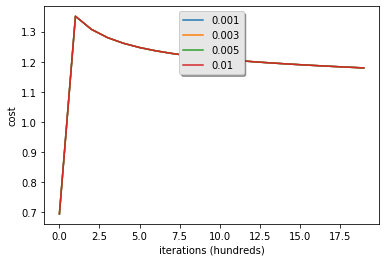

In [17]:
learning_rates = [0.001, 0.003, 0.005, 0.01]
models = {}
for i in learning_rates:
    print ("learning rate is: ",i)
    models[i] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 500, learning_rate = i, print_cost = False)
    print ("-------------------------------------------------------")